# Bible Explore

Exploring [Kaggle Bible Corpus](https://www.kaggle.com/oswinrh/bible) for similarity between passages.

Some extra information at [OpenBible](http://www.openbible.info/) and [Bible Databases](https://github.com/scrollmapper/bible_databases)

The current work is started in English and might be extended to other languages later on

In [91]:
import scipy as sp
import numpy as np
import pandas as pd
import csv
import os
import sys
import re
from queue import Queue
from pathlib import Path
import seaborn as sns
import bokeh
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
import networkx as nx
from pyvis.network import Network
import pickle

%matplotlib inline

In [2]:
# https://stackoverflow.com/questions/18424228/cosine-similarity-between-2-number-lists
# from scipy.spatial import distance
# scipy.spatial.distance.cosine

# or with numpy:
# from numpy import dot
# from numpy.linalg import norm

# cos_sim = dot(a, b)/(norm(a)*norm(b))

In [3]:
# this is for Tensorflow to use the good GPU instead of the first it sees
# os.environ["CUDA_VISIBLE_DEVICES"]="1"
# and this is to set tf to use the GPU

In [4]:
print(tf.__version__)
print(tf.config.list_physical_devices())


2.3.2
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'), PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:XLA_GPU:1', device_type='XLA_GPU')]


In [43]:
# loading data
# load chapters mappings
BASE_PATH_DB = Path("/home/leo/projects/AI/Datasets/text/religion/bible/kaggle-bible-corpus")
KEY_PATH_DB = BASE_PATH_DB / "key_english.csv"

corpus_path = BASE_PATH_DB / "t_asv.csv"
with open(corpus_path, newline='') as f:
    corpus = csv.reader(f)
    corpus_db = [r for r in corpus]
    verses = [r[-1] for r in corpus_db[1:]]  # omit the first line; It's the header

In [45]:
verses[0]

'In the beginning God created the heavens and the earth.'

In [51]:
key_verse_map = {}

with open(KEY_PATH_DB, newline='') as f:
    rows = csv.reader(f)
    kvs = [r for r in rows]
    key_verse_map = { i[0] : i[1] for i in kvs[1:]}

In [52]:
key_verse_map

{'1': 'Genesis',
 '2': 'Exodus',
 '3': 'Leviticus',
 '4': 'Numbers',
 '5': 'Deuteronomy',
 '6': 'Joshua',
 '7': 'Judges',
 '8': 'Ruth',
 '9': '1 Samuel',
 '10': '2 Samuel',
 '11': '1 Kings',
 '12': '2 Kings',
 '13': '1 Chronicles',
 '14': '2 Chronicles',
 '15': 'Ezra',
 '16': 'Nehemiah',
 '17': 'Esther',
 '18': 'Job',
 '19': 'Psalms',
 '20': 'Proverbs',
 '21': 'Ecclesiastes',
 '22': 'Song of Solomon',
 '23': 'Isaiah',
 '24': 'Jeremiah',
 '25': 'Lamentations',
 '26': 'Ezekiel',
 '27': 'Daniel',
 '28': 'Hosea',
 '29': 'Joel',
 '30': 'Amos',
 '31': 'Obadiah',
 '32': 'Jonah',
 '33': 'Micah',
 '34': 'Nahum',
 '35': 'Habakkuk',
 '36': 'Zephaniah',
 '37': 'Haggai',
 '38': 'Zechariah',
 '39': 'Malachi',
 '40': 'Matthew',
 '41': 'Mark',
 '42': 'Luke',
 '43': 'John',
 '44': 'Acts',
 '45': 'Romans',
 '46': '1 Corinthians',
 '47': '2 Corinthians',
 '48': 'Galatians',
 '49': 'Ephesians',
 '50': 'Philippians',
 '51': 'Colossians',
 '52': '1 Thessalonians',
 '53': '2 Thessalonians',
 '54': '1 Timothy

In [40]:
# TF Universal Sentence Encoder models
#@title Load the Universal Sentence Encoder's TF Hub module
MODELS_BASE_PATH = "/home/leo/projects/AI/Datasets/Tensorflow/tf-hub/"
# module_url = os.path.join(BASE_PATH, "universal-sentence-encoder-lite_2")
module_url = os.path.join(MODELS_BASE_PATH, "universal-sentence-encoder-multilingual_3")
# module_url = "https://tfhub.dev/google/universal-sentence-encoder-multilingual/3"
# module_url = "https://tfhub.dev/google/universal-sentence-encoder-lite/2"
# module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
# module_url = 'https://tfhub.dev/google/universal-sentence-encoder-large/5'

In [10]:
model = hub.load(module_url)
print ("module %s loaded" % module_url)

def embed(input):
  return model(input)

module /home/leo/projects/AI/Datasets/Tensorflow/tf-hub/universal-sentence-encoder-multilingual_3 loaded


In [11]:
# I don't get wht this consumes so much CPU and memory and is even slower than the full cpu version
# %%time

# with tf.device('/GPU:1'):
#     model = hub.load(module_url)
#     print ("module %s loaded" % module_url)

#     def embed(input):
#       return model(input)

#     bible_embeddings = embed(verses)

In [12]:
%%time

bible_embeddings = embed(verses)

CPU times: user 2min 30s, sys: 33.6 s, total: 3min 4s
Wall time: 29.7 s


In [13]:
# bible_embeddings[0]

In [14]:
%%time
# similarity by inner product
similarity_matrix_inner = np.inner(bible_embeddings, bible_embeddings)

CPU times: user 11.2 s, sys: 738 ms, total: 12 s
Wall time: 3.09 s


In [15]:
similarity_matrix_inner.shape

(31103, 31103)

In [16]:
def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

the matrix must be symmetric

In [17]:
check_symmetric(similarity_matrix_inner)

True

In [18]:
# labels = 

In [19]:
# too big for my PC 
# sns.set(font_scale=1.2)
# g = sns.heatmap(
#   similarity_matrix_inner,
# #       xticklabels=labels,
# #       yticklabels=labels,
#   vmin=0,
#   vmax=1,
#   cmap="YlOrRd")
# g.set_xticklabels(labels, rotation=90)
# g.set_title("Semantic Textual Similarity")


In [20]:
%%time
# get the closest and farthest ~ N for each
# https://www.kite.com/python/answers/how-to-find-the-n-maximum-indices-of-a-numpy-array-in-python
# https://numpy.org/doc/stable/reference/generated/numpy.argpartition.html
# https://numpy.org/doc/stable/reference/generated/numpy.partition.html

n = 21  # such as n>1 , when n==1 it shows only self-similarity
partitions = np.argpartition(similarity_matrix_inner, -n, axis=0)
closests = partitions[-n:]
farthest = partitions[:n]

CPU times: user 13.7 s, sys: 625 ms, total: 14.3 s
Wall time: 14.4 s


In [21]:
len(closests)
closests[0].shape

(31103,)

In [22]:
%%time
# now there are 2 arrays, each with verses number of elements, each array contains 
n_close = np.array(closests).transpose()
n_far = np.array(farthest).transpose()

CPU times: user 0 ns, sys: 3.56 ms, total: 3.56 ms
Wall time: 3.34 ms


In [23]:
similarity_matrix_inner.shape, n_close.shape, n_far.shape

((31103, 31103), (31103, 21), (31103, 21))

In [53]:
n_close[:2]

array([[15337, 31055, 26045, 19212, 24736, 16628, 13772, 26046, 15845,
        18579, 16474, 29973,   148,  5200, 28593,    31, 16625,    16,
           34, 15380,     0],
       [12522,  1910,   182,   190,    27, 14133, 19050,   194, 17829,
            8, 30527,  1928,   149,   176,   177, 25278,   178,     1,
           36,    37, 17530]])

In [24]:
# clean up memory ..
del(closests)
del(farthest)


Show the similarity values for a few points

In [25]:
similarity_matrix_inner[0][n_close[0][:20]]

array([0.5309429 , 0.53220767, 0.535607  , 0.54301083, 0.55235803,
       0.57052946, 0.55402035, 0.5800376 , 0.5822105 , 0.5618566 ,
       0.56626326, 0.57259107, 0.60005933, 0.5615088 , 0.5582243 ,
       0.6272632 , 0.65638304, 0.6330644 , 0.70625603, 0.64020944],
      dtype=float32)

In [26]:
similarity_matrix_inner[0][n_far[0]]

array([ 0.09364344,  0.08305697,  0.06654037,  0.12651277,  0.07592306,
        0.14878714,  0.13647093,  0.13357072,  0.05880683, -0.02358215,
        0.06586871,  0.11249685,  0.14682116,  0.0791003 ,  0.10768902,
        0.11913791,  0.13447869,  0.15217146,  0.11318401,  0.13786386,
        0.05275048], dtype=float32)

In [27]:
# n_close_distance = np.take_along_axis(similarity_matrix_inner, n_close, axis=0)  #this does not work

In [28]:
# n_close_distance = similarity_matrix_inner[tuple(n_close)]  # this does not work either
# n_close_distance = similarity_matrix_inner[n_close]  # this does not work either, it overloads the memory

In [29]:
# tnclose = tuple(n_close)  

In [30]:
# n_far_distance =  similarity_matrix_inner[n_far]  # Nope, this overloads the memory

extract similarity values for the close elements (this will be useful for displaying later the 

In [31]:
%%time
# somehow this is not sorted as it should
close_matrix = np.array([similarity_matrix_inner[i][n_close[i]] for i in range(similarity_matrix_inner.shape[0])])
far_matrix = np.array([similarity_matrix_inner[i][n_far[i]] for i in range(similarity_matrix_inner.shape[0])])

CPU times: user 73.4 ms, sys: 3.51 ms, total: 76.9 ms
Wall time: 77.2 ms


In [32]:
close_matrix.shape, far_matrix.shape

((31103, 21), (31103, 21))

In [33]:
close_matrix[0]

array([0.5309429 , 0.53220767, 0.535607  , 0.54301083, 0.55235803,
       0.57052946, 0.55402035, 0.5800376 , 0.5822105 , 0.5618566 ,
       0.56626326, 0.57259107, 0.60005933, 0.5615088 , 0.5582243 ,
       0.6272632 , 0.65638304, 0.6330644 , 0.70625603, 0.64020944,
       1.0000001 ], dtype=float32)

In [34]:
# now I need to understand many MANY things, 
# compute the labels and IDs for each row
# give the text for each row
# create a networkx connection graph with it


Compute Human Readable Labels

In [55]:
corpus_db[0]

['id', 'b', 'c', 'v', 't']

In [39]:
corpus_db[11000:11003]

[['13023016', '13', '23', '16', 'The sons of Gershom: Shebuel the chief.'],
 ['13023017',
  '13',
  '23',
  '17',
  'And the sons of Eliezer were: Rehabiah the chief; and Eliezer had no other sons; but the sons of Rehabiah were very many.'],
 ['13023018', '13', '23', '18', 'The sons of Izhar: Shelomith the chief.']]

In [71]:
%%time
# db contains all the information AND the embeddings, this also contains the graph information
bible_db = {}

for i in range(1, len(corpus_db)-1):
    verse = corpus_db[i]
#     k_id = int(verse[0])
    val = {
        'id': int(verse[0]),
        'name': f"{key_verse_map[verse[1]]} {verse[2]}:{verse[3]}",
        'book_id': int(verse[1]),
        'chapter_id': int(verse[2]),
        'verse_id': int(verse[3]),
        'text': verse[4],
        'embedding': bible_embeddings[i],
        'close_to': n_close[i],  # ids
        'close_to_distance': close_matrix[i], 
        'far_from': n_far[i],  # ids
        'far_from_distance': far_matrix[i], 
    }
    bible_db[i-1] = val

CPU times: user 1.55 s, sys: 26.9 ms, total: 1.58 s
Wall time: 1.59 s


In [72]:
bible_db[10]

{'id': 1001011,
 'name': 'Genesis 1:11',
 'book_id': 1,
 'chapter_id': 1,
 'verse_id': 11,
 'text': "And God said, Let the earth put forth grass, herbs yielding seed, `and' fruit-trees bearing fruit after their kind, wherein is the seed thereof, upon the earth: and it was so.",
 'embedding': <tf.Tensor: shape=(512,), dtype=float32, numpy=
 array([ 0.09106142,  0.03639635,  0.07232352,  0.0180516 ,  0.00536718,
         0.03608396,  0.05259072, -0.02857068,  0.04545586,  0.06467625,
         0.06814095, -0.03513066,  0.02862555,  0.02917071, -0.00231802,
         0.00881511, -0.05753801,  0.04993311, -0.01497626,  0.01349286,
         0.01813623, -0.02739129,  0.03048592, -0.03268808, -0.07027489,
         0.06431985, -0.05512333, -0.06109827, -0.0350656 ,  0.0462325 ,
        -0.05182962, -0.06845409, -0.0513493 ,  0.02085048,  0.00632241,
         0.00783822,  0.04397808, -0.00993006, -0.05865693,  0.02339393,
         0.00523461, -0.06789356, -0.07403339, -0.0083824 , -0.04236085,
  

In [73]:
# save the DB
BIBLE_DB_PATH = "../db/bible-db.pkl"
with open(BIBLE_DB_PATH, 'wb') as f:
    pickle.dump(bible_db, f, pickle.HIGHEST_PROTOCOL)
    
## kind of big, 86 mb

In [69]:
BIBLE_EMBEDDINGS_PATH = "../db/bible-embeddings.pkl"
with open(BIBLE_EMBEDDINGS_PATH, 'wb') as f:
    pickle.dump(bible_embeddings, f, pickle.HIGHEST_PROTOCOL)
    

In [84]:
# function to get the subgraph 

def _get_node_edge(bible_db, node_id, close_points):
    node = bible_db[node_id]
#     group = node['book_id']
#     label = node['name']
#     title = node['text']
#     txt = node['text']
    nd_info = (node_id, node)
    nd_weight = zip(node['close_to'], node['close_to_distance'])
    nd_edges = []
    for n,w in nd_weight:
        if n != node_id:
            # distance is farthest the smaller it is, so changing it to make the reverse relation
            nd_edges.append((node_id, n, 1/w))
        if len(nd_edges) >= close_points:
            break
    return nd_info, nd_edges

In [144]:
def get_subgraph(bible_db, node_id, close_points=5, levels=2):
    """
    Get the subgraph from a node id
    bible_db: the entire bible database in a dict
    node_id: the node id
    close_points: the number of close points from each, => each point will have at most close_points outgoing edges
    levels: number of levels to go in depth for connections
    returns a networkx graph of the subgraph from the complete db centering the subgraph in the given node_id
    """
    g = nx.Graph()
    if node_id not in bible_db:
        # there is no graph to build
        return g
    # Recursive is SO intuitive, but will explode the stack and memory for big graphs
    nid = node_id
    nodes_to_add = []  # (node_id, group, size, label, title, txt)
    edges_to_add = []  # (node_id, node_id, weight)
    discovered = set()
    q = Queue()
    q.put(node_id)
    cnt = 0
    # this tree/ graph transversal is wrong, but I need to be able to build something first
    while not q.empty() and cnt < (levels*close_points):
        v = q.get()
        discovered.add(v)
        nd_info, nd_edges = _get_node_edge(bible_db, v, close_points)
        nodes_to_add.append(nd_info)
        edges_to_add.extend(nd_edges)
        for te,ne,w in nd_edges:
            if ne not in discovered:
                q.put(ne)
        cnt+=1
    # TODO
    for n in nodes_to_add:
        nid, node = n
        g.add_node(nid, group=node['book_id'], title=node['name'], data=node['text'])
#         g.add_node(int(nid), size=20, group=node['book_id'], title=node['name'], data=node['text'])
    for se, ee, w in edges_to_add:
        g.add_edge(se, ee, weight=w)
        
    return nodes_to_add, edges_to_add, g

In [145]:
nodes, edges, sg = get_subgraph(bible_db, 127, close_points=6, levels=1)

In [146]:
[n[0] for n in nodes]

[127, 124, 3688, 3627, 120, 3778]

In [147]:
edges

[(127, 124, 1.9206106677977026),
 (127, 3688, 1.9199284450496363),
 (127, 3627, 1.916513204031377),
 (127, 120, 1.9039842317590059),
 (127, 3778, 1.8744770173663696),
 (127, 123, 1.6678171013618526),
 (124, 131, 2.034440868828576),
 (124, 291, 2.016696401246376),
 (124, 130, 2.0010460122542066),
 (124, 133, 1.8872998292148948),
 (124, 116, 1.651623309118631),
 (124, 114, 1.838141341684569),
 (3688, 3682, 1.5681176997522748),
 (3688, 3669, 1.563569459073628),
 (3688, 4523, 1.5572207443599393),
 (3688, 4716, 1.5561025387601537),
 (3688, 3673, 1.5176644569134303),
 (3688, 3631, 1.5032326657382948),
 (3627, 3781, 1.7753932624814825),
 (3627, 3640, 1.0846278081361618),
 (3627, 3638, 1.0528380199093454),
 (3627, 3622, 1.6277755850583049),
 (3627, 3624, 1.2592107071386203),
 (3627, 3626, 1.1481541146940346),
 (120, 130, 1.638394880016),
 (120, 281, 1.6290705484207968),
 (120, 6878, 1.6230633196475492),
 (120, 280, 1.6176292611549128),
 (120, 123, 1.5994090928244018),
 (120, 117, 1.59939018612

In [148]:
type(sg)

networkx.classes.graph.Graph

In [149]:
sg.nodes[127]

{'group': 1,
 'title': 'Genesis 5:22',
 'data': 'and Enoch walked with God after he begat Methuselah three hundred years, and begat sons and daughters:'}

In [150]:
sg.edges

EdgeView([(127, 124), (127, 3688), (127, 3627), (127, 120), (127, 3778), (127, 123), (124, 131), (124, 291), (124, 130), (124, 133), (124, 116), (124, 114), (3688, 3682), (3688, 3669), (3688, 4523), (3688, 4716), (3688, 3673), (3688, 3631), (3627, 3781), (3627, 3640), (3627, 3638), (3627, 3622), (3627, 3624), (3627, 3626), (120, 130), (120, 281), (120, 6878), (120, 280), (120, 123), (120, 117), (3778, 12030), (3778, 3677), (3778, 2662), (3778, 11744), (3778, 4530), (3778, 3625)])

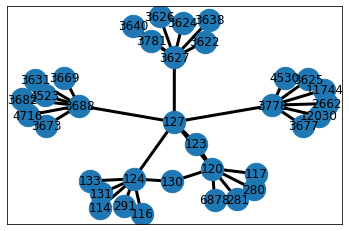

In [160]:
options = {
#     'node_color': 'light-blue',
    'node_size': 500,
    'width': 3,
#     'arrowstyle': '-|>',
#     'arrowsize': 12,
}
nx.draw_networkx(sg, **options)
plt.show()

In [161]:
nt = Network('800px', '800px')
nt.from_nx(sg)

AssertionError: 

In [ ]:
def get_closest_points(txt, n=10, algorithm='inner'):
    """
    txt: the text to look for similarities
    n: the number of closest matches that will be searched
    algorithm: inner|cosine  # the algorithm to determine how the proximity is computed
    returns the closest n points to the input text based on the proximity algorithm
    """
    n_close = []
    # TODO
    # embed input
    # compute proximity with all the existing points
    # get the closest n points ids
    return n_close
